# Visualisation of the temperature in my room


This personal project aims to learn to use a temperature sensor on Raspberry Pi and conduct the exploratory on the data obtained from the sensor.

I used Raspberry Pi 3 connected with a digital thermometer (model DS18B20) to measure temperature in my room every 10 minutes. The code for recording the temperature can be found [here](https://github.com/supvolume/measure_temperature/blob/main/temp_sensor.py). The recorded data is in CSV format.

According to all collected data from 16 September 2020, 16:33 to 22 December 2020, 14:09, the average temperature in my room is 23.85 °C. The minimum temperature is 17.44 °C and the maximum is 30.56 °C. 
For the selection of the most suitable level of granularity for visualising daily temperature, multiple levels of granularity were visualised and compared. The result is to aggregation data into an average of 1 hour.
Moreover, The room maximum and minimum temperature show linear correlations to the outside temperature.



## Table of Contents

- [Data preparation](#data_prep)
- [EDA on daily temperature graph](#eda)
- [Compare room minimum and maximum temperature to the temperature outside](#max_min)
- [References](#ref)

## Data preparation <a id='data_prep'></a>

The temperature data was recorded in multiple CSV files, the files will be read and join into a dataframe. It consists of three columns, date, time, and temperature. The temperature column will be converted into numeric. The date and time columns will be merge and convert into datetime type. Note that it will be separated as date and time again for visualisation purpose as seaborn does not accept datetime data type for axis.


In [1]:
# Import
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats  # for finding corelation between outside and room temp
import matplotlib.patches as mpatches  # for create custom legend

In [2]:
# Prepare the temperature data
# List of dataframe
temp_file_list = []

# Read the temperature files
for file in os.listdir("temp_record/"):
    if file.endswith(".txt"):
        record = pd.read_csv("temp_record/"+file,  header=None, names=["date", "time", "temperature"])
        temp_file_list.append(record)

# Concat all files in list into a dataframe
temp_df = pd.concat(temp_file_list, axis=0)

# Convert string into float
temp_df["temperature"] = pd.to_numeric(temp_df["temperature"], errors="coerce")

# Remove null row
temp_df.dropna(inplace=True)

In [3]:
# Create datetime column
dt_df = temp_df.copy()
dt_df["datetime"] = temp_df["date"]+" "+temp_df["time"]
dt_df.drop(["date", "time"], axis=1, inplace=True)
dt_df["datetime"] = pd.to_datetime(dt_df["datetime"])
dt_df.head()

,temperature,datetime
0,24.687,2020-09-16 16:33:20.677699
1,24.687,2020-09-16 16:43:21.680049
2,24.500,2020-09-16 16:53:22.634034
3,24.375,2020-09-16 17:03:23.566841
4,24.312,2020-09-16 17:13:24.600617


In [4]:
dt_df.describe(datetime_is_numeric=True)

,temperature,datetime
count,13749.000000,13749
mean,23.851244,2020-11-04 08:38:18.934868736
min,17.437000,2020-09-16 16:33:20.677699
25%,22.437000,2020-10-10 20:53:16.890990080
50%,23.812000,2020-11-04 18:34:50.884818944
75%,25.062000,2020-11-28 16:22:05.646606080
max,30.562000,2020-12-22 14:09:02.517132
std,2.093345,NaN


## EDA on daily temperature graph <a id='eda'></a>

#### The example of my room daily temperature

Because the temperature was collected every 10 minutes which has higher detail than required as it can be seen from the example graph of room temperature on 17 September 2020 (Fig. 1). The interesting point of the graph is the lowest temperature and three peaks of higher temperature which occur because I turned on the heater, however, the data fluctuates along with the graph, which is not significant to the information gain from the graph.

It is also lower the performance in creating a visualisation. Thus, a suitable level of granularity will be found.


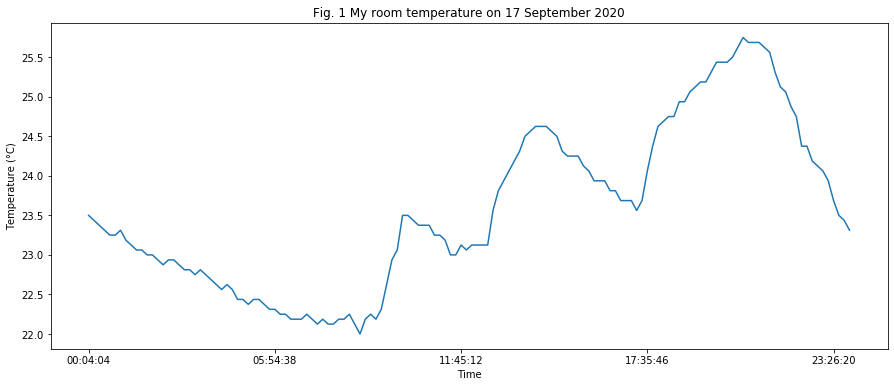

In [5]:
# The example graph of daily temperature
f, ax = plt.subplots(figsize=(15,6)) 
eg_date = "2020-09-17"
ten_min = temp_df[temp_df["date"]==eg_date].reset_index(drop=True)
g = sns.lineplot(data=ten_min, x="time", y="temperature")
g.set_xticks([0, 35, 70, 105, 140]) 
g.set_xticklabels(["00:04:04","05:54:38","11:45:12", "17:35:46","23:26:20"])
plt.title("Fig. 1 My room temperature on 17 September 2020")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()
#print(list(ax.get_xticklabels()))

#### Find the suitable granularity level

To find the suitable granularity level, the data of example date will be aggregated to 30 minutes, 1 hour, and 2 hours, compared to 10 minutes. The data after aggregation is display in Fig. 2. From the graph, 30 minutes and 1 hour aggregate level show the valleys and peaks similar to 10 minutes data. However, at 2 hours data, the valley at 11:40 disappear.

Thus, to maintain significant detail and improve performance for visualisation of daily temperature, aggregate data into one hour should be the suitable level of granularity.


In [6]:
# Adjust the timestamp scale to be able to plot on the same axis with other
tm_m = dt_df.resample("10min", on="datetime").mean().reset_index()

# Group time in range of 30 min
tt_m = dt_df.resample("30min", on="datetime").mean().reset_index()

# Group time in range of 1 hour
one_hour = dt_df.resample("60min", on="datetime").mean().reset_index()

# Group time in range of 2 hour
two_hour = dt_df.resample("120min", on="datetime").mean().reset_index()

# Split date and time
df_list = [tm_m, tt_m, one_hour, two_hour]
for i in df_list:
    i["date"] = i["datetime"].dt.strftime("%Y-%m-%d")
    i["time"] = i["datetime"].dt.strftime("%H:%M:%S.%f")
    
# Select only the example date (2020-09-17)
tt_m_eg = tt_m[tt_m["date"]==eg_date].reset_index(drop=True)
one_hour_eg = one_hour[one_hour["date"]==eg_date].reset_index(drop=True)
tm_m_eg = tm_m[tm_m["date"]==eg_date].reset_index(drop=True)
two_hour_eg = two_hour[two_hour["date"]==eg_date].reset_index(drop=True)

# Identify granularity level
tm_m_eg["granularity"] = "10 min"
tt_m_eg["granularity"] = "30 min"
one_hour_eg["granularity"] = "1 hour"
two_hour_eg["granularity"] = "2 hour"
all_lvl = pd.concat([tm_m_eg, tt_m_eg, one_hour_eg, two_hour_eg])


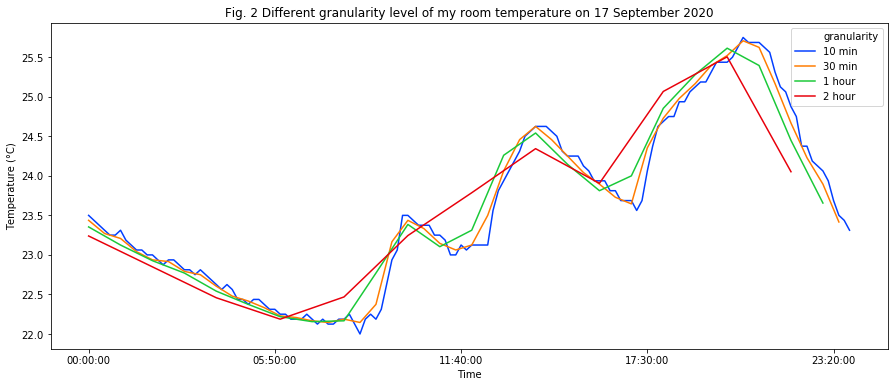

In [7]:
# Graph for select suitable granularity level
f, ax = plt.subplots(figsize=(15,6)) 
g = sns.lineplot(data=all_lvl, x="time", y="temperature", hue="granularity", palette="bright")
plt.title("Fig. 2 Different granularity level of my room temperature on 17 September 2020")
g.set_xticks([0, 35, 70, 105, 140]) 
g.set_xticklabels(["00:00:00","05:50:00","11:40:00", "17:30:00","23:20:00"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

#### All daily my room temperature

The graph of all daily temperature from 17 September 2020 to 21 December 2020 is shown in Fig. 3.
Though the recorded temperature was from spring (September) to summer (December), the trend of increasing temperature is not clear in the graph. This might happen because the room has a heater and the temperature in the room is more stable than the temperature outside. Moreover, the overall change in temperature from spring to summer is not as clear as summer to winter (or winter to summer) as shown in the graph of outside temperature (Fig. 5).


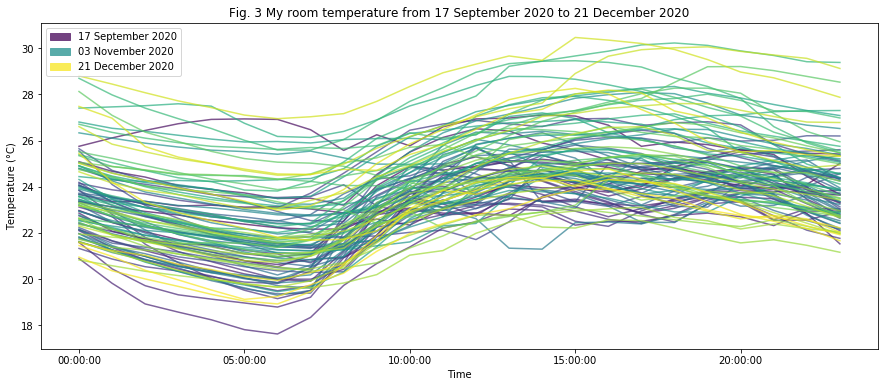

In [8]:
# Graph for all daily room temperature
f, ax = plt.subplots(figsize=(15,6))
g = sns.lineplot(data=one_hour[8:2312], x="time", y="temperature", hue="date", palette="viridis")

# Legend
first_day = mpatches.Patch(color=[0.451, 0.259, 0.506], label="17 September 2020")
mid_day = mpatches.Patch(color=[0.345, 0.671, 0.663], label="03 November 2020")
last_day = mpatches.Patch(color=[0.976, 0.925, 0.345], label="21 December 2020")
plt.legend(handles=[first_day, mid_day, last_day])
# Ref for custom legend: https://matplotlib.org/3.2.1/tutorials/intermediate/legend_guide.html
# Ref for color: https://matplotlib.org/tutorials/colors/colors.html

plt.setp(g.lines, alpha=.7) 
plt.title("Fig. 3 My room temperature from 17 September 2020 to 21 December 2020")
g.set_xticks([0, 5, 10, 15, 20]) 
g.set_xticklabels(["00:00:00","05:00:00","10:00:00", "15:00:00","20:00:00"])
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

## Compare room minimum and maximum temperature to the temperature outside <a id='max_min'></a>

#### My room daily minimum and maximum temperature

The raw temperature data get aggregate to find the minimum and maximum temperature. To reduce misleading information, the day that fails to record more than 2 hours will be removed. The graph shows slightly resemble of the minimum and maximum temperature in my room when compares them in Fig. 4.


In [9]:
# Get min and max of each day
daily_temp = dt_df.resample("D", on="datetime")["temperature"].agg(["min", "max", "count"]).reset_index()

# Remove null row
daily_temp.dropna(inplace=True)

# Remove row that miss more than 2 hour of record
daily_temp.drop(daily_temp[daily_temp["count"] < 132].index, inplace=True)

# Drop count column
daily_temp.drop("count", axis=1, inplace=True)

# Convert to long format
daily_temp = pd.melt(daily_temp, id_vars=["datetime"], value_vars=["min", "max"])

daily_temp.head()

,datetime,variable,value
0,2020-09-17,min,22.000
1,2020-09-18,min,20.937
2,2020-09-19,min,25.312
3,2020-09-20,min,22.750
4,2020-09-21,min,22.562


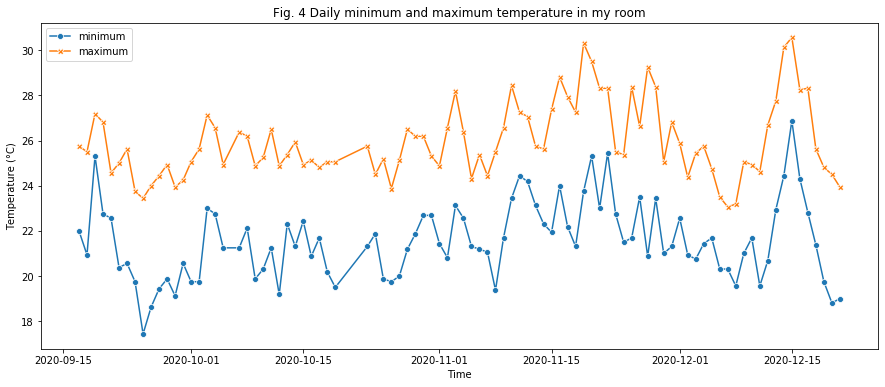

In [10]:
f, ax = plt.subplots(figsize=(15,6)) 
g = sns.lineplot(data=daily_temp, x="datetime", y="value", 
                 hue="variable", markers=True, dashes=False, style="variable")
ax.legend(labels=["minimum", "maximum"], loc="upper left")
plt.title("Fig. 4 Daily minimum and maximum temperature in my room")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

#### Minimum and maximum outside temperature

The data that will be used for comparison is from the Bureau of Meteorology (2021), measure at Moorabbin Airport, Victoria, Australia, which is the nearest weather station to my room. The graph of all year minimum and maximum temperature from the weather station (Fig. 5) shows the increasing and decreasing of temperature trend in each month. The trends are similar between the minimum and maximum temperature.


In [11]:
# Read weather station temperature data
weather_sta_max = pd.read_csv("weather_station_max.csv")
weather_sta_min = pd.read_csv("weather_station_min.csv")


# Merge datetime column
ws_list = [weather_sta_max, weather_sta_min]
for i in ws_list:
    i[["Year", "Month", "Day"]] = i[["Year", "Month", "Day"]].astype("str")
    i["datetime"] = i["Year"] + "-" + i["Month"] + "-" + i["Day"]
    i["datetime"] = pd.to_datetime(i["datetime"])
    
# Drop unuse column
acc_name = ["Days of accumulation of maximum temperature", 
            "Days of accumulation of minimum temperature"]
for i in range(len(ws_list)):
    ws_list[i].drop(["Product code", 
            "Bureau of Meteorology station number",
            "Year",
            "Month",
            "Day",
            acc_name[i],
            "Quality"],
           axis=1, inplace=True)
    ws_list[i].head()

# Join min and max from weather station
station_temp = pd.merge(weather_sta_max, weather_sta_min)
station_temp.columns = ["max", "datetime", "min"]

# Convert to long format
station_temp = pd.melt(station_temp, id_vars=["datetime"], value_vars=["min", "max"])
station_temp.head()

,datetime,variable,value
0,2020-01-01,min,10.0
1,2020-01-02,min,11.8
2,2020-01-03,min,12.2
3,2020-01-04,min,15.5
4,2020-01-05,min,12.7


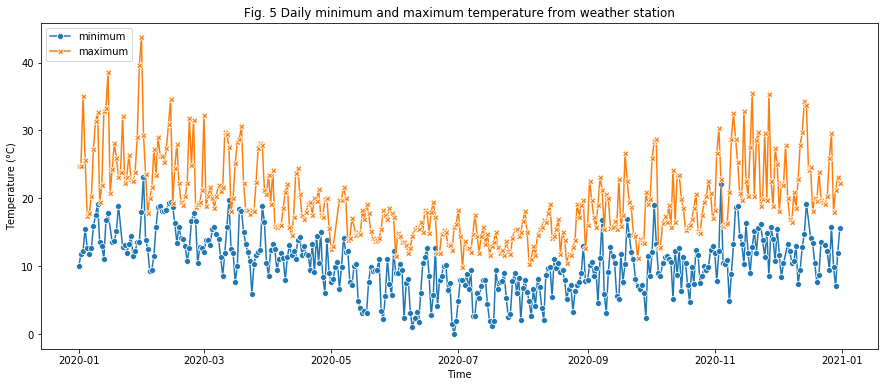

In [12]:
f, ax = plt.subplots(figsize=(15,6)) 
sns.lineplot(data=station_temp, x="datetime", y="value", 
             hue="variable", markers=True, dashes=False, style="variable")
ax.legend(labels=["minimum", "maximum"], loc="upper left")
plt.title("Fig. 5 Daily minimum and maximum temperature from weather station")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

#### Compare room minimum and maximum temperature to the outside minimum and maximum temperature

When compare my room and outside minimum (Fig. 6) and maximum (Fig. 7) temperature, the temperature inside the room is more stable (less fluctuated) than the outside temperature. Especially the minimum temperature in the room is significantly lower than the outside temperature during all the period of data collection. The main reason is that the heater was used during the day time when it was a cold day, the room temperature during spring is warmer than outside and the room was build to preserve the heat.


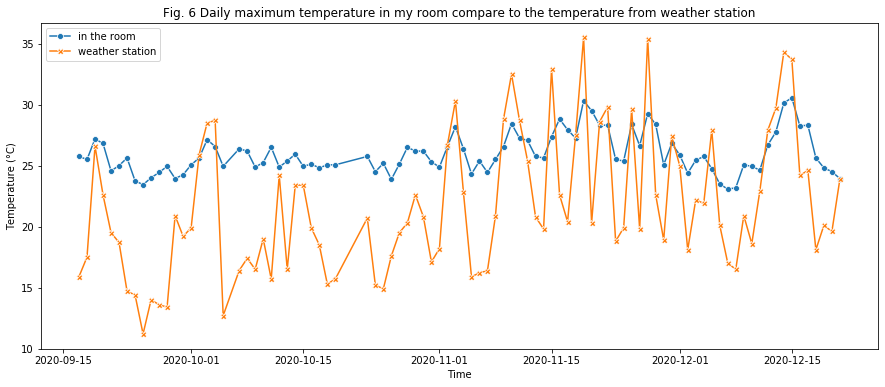

In [13]:
# Compare the maximum temperature in the room and weather station
max_temp = pd.merge(daily_temp[daily_temp["variable"]=="max"], 
                    station_temp[station_temp["variable"]=="max"], 
                    on="datetime")
max_temp = max_temp[["datetime", "value_x", "value_y"]]
max_temp.columns = ["datetime", "room_temp", "station_temp"]

# Convert to long format
max_temp_l = pd.melt(max_temp, id_vars=["datetime"], value_vars=["room_temp", "station_temp"])

f, ax = plt.subplots(figsize=(15,6)) 
sns.lineplot(data=max_temp_l, x="datetime", y="value", 
             hue="variable", markers=True, dashes=False, style="variable")
ax.legend(labels=["in the room", "weather station"], loc="upper left")
plt.title("Fig. 6 Daily maximum temperature in my room compare to the temperature from weather station")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

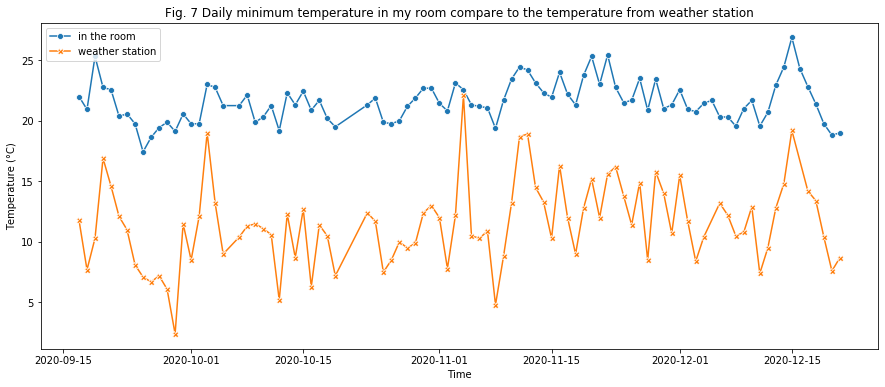

In [14]:
# Compare the minimum temperature in the room and weather station
min_temp = pd.merge(daily_temp[daily_temp["variable"]=="min"], 
                    station_temp[station_temp["variable"]=="min"], 
                    on="datetime")
min_temp = min_temp[["datetime", "value_x", "value_y"]]
min_temp.columns = ["datetime", "room_temp", "station_temp"]

# Convert to long format
min_temp_l = pd.melt(min_temp, id_vars=["datetime"], value_vars=["room_temp", "station_temp"])

f, ax = plt.subplots(figsize=(15,6)) 
sns.lineplot(data=min_temp_l, x="datetime", y="value", 
             hue="variable", markers=True, dashes=False, style="variable")
ax.legend(labels=["in the room", "weather station"], loc="upper left")
plt.title("Fig. 7 Daily minimum temperature in my room compare to the temperature from weather station")
plt.xlabel("Time")
plt.ylabel("Temperature (°C)") 
plt.show()

#### Find the relationship between room and outside temperature

To find the level of correlation between inside and outside temperature, the Pearson correlation coefficient (r) will be used as a measurement. From the graphs of the relationship between daily maximum (Fig. 8) and minimum (Fig. 9) temperature from outside temperature and inside the room, both of the relationships are close to the linear model. However, the data points of daily maximum temperature are more distributed than the daily minimum temperature. The correlation coefficient of the daily maximum temperature of room and outside is 0.7380, while the daily minimum is 0.7493 which is slightly higher. Though the temperature outside seems to be the major factor that influences the room temperature, there are other factors that can affect the room temperature as well, such as the use of a heater, cooking, room insulator, etc.


In [15]:
# Find the coefficient of room and outside max temp
np_max_room = max_temp["room_temp"].to_numpy()
np_max_sta = max_temp["station_temp"].to_numpy()
max_corelation = stats.pearsonr(np_max_room, np_max_sta)[0]
print("Pearson correlation coefficient (r) between max room temperature and max outside temperature: "
      + "{:.4f}".format(round(max_corelation, 4)))

Pearson correlation coefficient (r) between max room temperature and max outside temperature: 0.7380


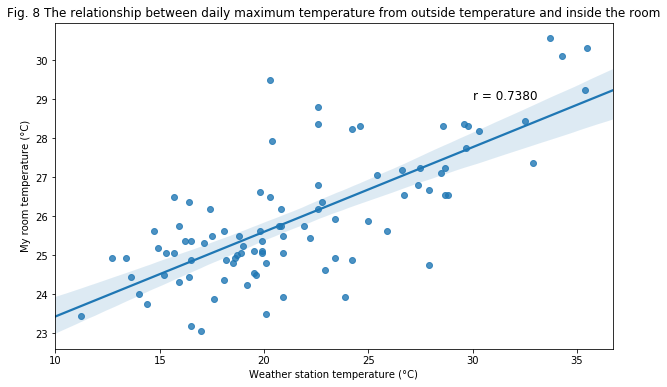

In [16]:
# Graph of the relationship beteen room and outside max temp
f, ax = plt.subplots(figsize=(10,6)) 
sns.regplot(data=max_temp, x="station_temp", y="room_temp")
ax.text(30, 29, "r = "+ "{:.4f}".format(round(max_corelation, 4)), fontsize = 12)
plt.title("Fig. 8 The relationship between daily maximum temperature from outside temperature and inside the room")
plt.xlabel("Weather station temperature (°C)")
plt.ylabel("My room temperature (°C)") 
plt.show()

In [17]:
# Find the coefficient of room and outside min temp
min_temp.dropna(inplace=True)
np_min_room = min_temp["room_temp"].to_numpy()
np_min_sta = min_temp["station_temp"].to_numpy()
min_corelation = stats.pearsonr(np_min_room, np_min_sta)[0]
print("Pearson correlation coefficient (r) between min room temperature and min outside temperature: "
      + "{:.4f}".format(round(min_corelation, 4)))

Pearson correlation coefficient (r) between min room temperature and min outside temperature: 0.7493


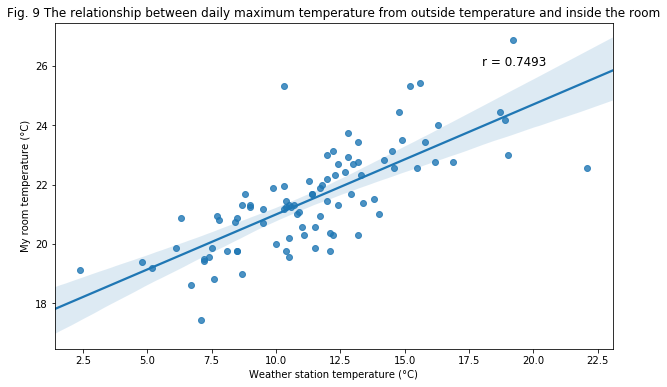

In [18]:
# Graph of the relationship beteen room and outside min temp
f, ax = plt.subplots(figsize=(10,6)) 
sns.regplot(data=min_temp, x="station_temp", y="room_temp")
ax.text(18, 26, "r = "+ "{:.4f}".format(round(min_corelation, 4)), fontsize = 12)
plt.title("Fig. 9 The relationship between daily maximum temperature from outside temperature and inside the room")
plt.xlabel("Weather station temperature (°C)")
plt.ylabel("My room temperature (°C)") 
plt.show()

## References <a id='ref'></a>


Bureau of Meteorology. (2021). Retrieved from http://www.bom.gov.au/climate/data/

Legend guide — Matplotlib 3.2.1 documentation. (2021). Retrieved from https://matplotlib.org/3.2.1/tutorials/intermediate/legend_guide.html

Specifying Colors — Matplotlib 3.3.3 documentation. (2021). Retrieved from https://matplotlib.org/tutorials/colors/colors.html